# Public Data - Acceptance Criterion Analysis

https://wandb.ai/shlomihod/synthflow/groups/qsub-mult-full-v8/table?workspace=user-shlomihod

x10 all

In [1]:
from ast import literal_eval
from pathlib import Path

import pandas as pd
import seaborn as sns
import wandb
from matplotlib import pylab as plt
from tqdm import tqdm

## Extract Runs from API

In [2]:
def extract_run(run):
    record = {}
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    record.update(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    record.update({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    record["name"] = run.name

    return record

In [3]:
DATES = [
    "2023-08-01T00:00",
    "2023-08-28T00:00",
    "2023-08-28T12:00",
    "2023-08-29T00:00",
    "2023-08-29T12:00",
    "2023-08-30T00:00",
    "2023-08-30T12:00",
    "2023-08-31T00:00",
    "2023-08-31T12:00",
    "2023-09-01T00:00",
    "2023-09-01T12:00",
    "2023-09-02T00:00",
    "2023-10-01T00:00",
]

TOTAL_RUNS = 1152 * 10

RESULTS_PATH = Path("wandb.csv.gz")

api = wandb.Api(timeout=60)

In [4]:
if not RESULTS_PATH.exists():
    runs_by_date = (
        api.runs(
            "shlomihod/synthflow",
            {
                "group": "qsub-mult-full-v8",
                "$and": [
                    {
                        "created_at": {
                            "$lte": end,
                            "$gt": start,
                        }
                    }
                ],
            },
        )
        for start, end in zip(DATES, DATES[1:])
    )

    all_runs = (run for runs in runs_by_date for run in runs)
    run_results = [extract_run(run) for run in tqdm(all_runs, total=TOTAL_RUNS)]

    pd.DataFrame(run_results).to_csv(RESULTS_PATH, compression="gzip")

100%|█████████████████████████████████████| 11520/11520 [30:10<00:00,  6.36it/s]


## Load Results

In [5]:
def expand_dict_columns(df, prefix=None):
    new_df = df.copy()
    to_drop = []
    to_add = {}

    for col in new_df.columns:
        full_col_name = f"{prefix}.{col}" if prefix else col
        if (
            new_df[col]
            .apply(
                lambda x: isinstance(x, str) and (x.startswith("{") and x.endswith("}"))
            )
            .all()
        ):
            try:
                new_df[col] = new_df[col].apply(literal_eval)
            except (ValueError, SyntaxError):
                print(f"Skipping column {col} due to parsing error")
                continue

        if new_df[col].apply(isinstance, args=(dict,)).all():
            expanded_col = pd.json_normalize(new_df[col])
            expanded_col.columns = [
                f"{full_col_name}.{subcol}" for subcol in expanded_col.columns
            ]
            to_drop.append(col)
            to_add[full_col_name] = expanded_col

    return to_drop, to_add


def apply_changes(df, to_drop, to_add):
    df = df.drop(columns=to_drop)
    for prefix, new_cols in to_add.items():
        df = df.join(new_cols)
        _, next_add = expand_dict_columns(df, prefix=prefix)
        df = apply_changes(df, [], next_add)
    return df


def load(path):
    df = pd.read_csv(path, index_col=0)

    to_drop, to_add = expand_dict_columns(df)
    df = apply_changes(df, to_drop, to_add)

    # df = df[df["State"] == "finished"]
    df["dataset_projection.order"] = (
        df["dataset_projection.order"].fillna(0).astype(int).astype(str)
    )
    df = df.dropna(axis=1, how="all")

    # #assert df["id"].nunique() == 60
    # assert (df.groupby("id").size() >= 1).all()
    # # assert (df.groupby("id")["State"].apply(lambda g: (g == "finished").sum()) >= 5).all()

    for prompt in ["", "dp_"]:
        df[f"{prompt}acceptance/all-but-coef-and-privacy/check"] = df.filter(
            regex=f"^{prompt}acceptance/(?!all|coef|privacy).+/check$"
        ).all(axis=1)
        df[f"{prompt}acceptance/all-but-privacy/check"] = df.filter(
            regex=f"^{prompt}acceptance/(?!all|privacy).+/check$"
        ).all(axis=1)

    return df


df = load(RESULTS_PATH)

assert not df["acceptance/all/check"].isna().any()

df.shape

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_92932/2425386362.py:42: DtypeWarning: Columns (544,545,546,547,548) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=0)


(11520, 541)

## Analysis

In [6]:
df["id"].value_counts().value_counts().sort_index()

10    1152
Name: id, dtype: int64

In [7]:
id_acceptance_counts = df.groupby("id")[
    "acceptance/all-but-coef-and-privacy/check"
].sum()
accepted_ids = set(id_acceptance_counts[id_acceptance_counts > 0].index)
at_least_one_accepted_id_mask = df["id"].apply(lambda id_: id_ in accepted_ids)

print(f"{len(accepted_ids)=}")

df = df[at_least_one_accepted_id_mask]

len(accepted_ids)=120


In [8]:
id_acceptance_counts[id_acceptance_counts > 0].sort_values()

id
60d7-bc13-200e    1
60d7-1eea-f51f    1
60d7-3d1a-200e    1
60d7-3ff8-f51f    1
60d7-51f2-200e    1
                 ..
7dab-c965-200e    5
60d7-477b-200e    5
60d7-eef9-200e    6
60d7-f09e-200e    6
60d7-c965-200e    6
Name: acceptance/all-but-coef-and-privacy/check, Length: 120, dtype: int64

In [9]:
accepted_ids

{'2921-0856-f51f',
 '2921-0e2b-200e',
 '2921-0e2b-f51f',
 '2921-131e-200e',
 '2921-131e-f51f',
 '2921-1eea-200e',
 '2921-1eea-f51f',
 '2921-3d1a-200e',
 '2921-3d1a-f51f',
 '2921-477b-200e',
 '2921-477b-f51f',
 '2921-51de-f51f',
 '2921-51f2-200e',
 '2921-51f2-f51f',
 '2921-5a5f-200e',
 '2921-5a5f-f51f',
 '2921-7ec5-f51f',
 '2921-8328-200e',
 '2921-8328-f51f',
 '2921-9038-200e',
 '2921-903d-f51f',
 '2921-b56a-200e',
 '2921-b56a-f51f',
 '2921-b995-f51f',
 '2921-c3cb-200e',
 '2921-c965-200e',
 '2921-c965-f51f',
 '2921-d054-200e',
 '2921-d054-f51f',
 '2921-eef9-200e',
 '2921-eef9-f51f',
 '2921-f0e2-200e',
 '2921-f0e2-f51f',
 '2921-f7af-200e',
 '60d7-0469-200e',
 '60d7-0469-f51f',
 '60d7-0e2b-200e',
 '60d7-131e-200e',
 '60d7-131e-f51f',
 '60d7-1eea-200e',
 '60d7-1eea-f51f',
 '60d7-35d8-200e',
 '60d7-35d8-f51f',
 '60d7-3aa1-200e',
 '60d7-3d1a-200e',
 '60d7-3d1a-f51f',
 '60d7-3ff8-200e',
 '60d7-3ff8-f51f',
 '60d7-477b-200e',
 '60d7-477b-f51f',
 '60d7-51f2-200e',
 '60d7-51f2-f51f',
 '60d7-5a5f-

In [10]:
{
    f"{trans}-{order}"
    for trans, _, order in {tuple(col.split("-")) for col in accepted_ids}
    if order != "3b41"
}

# 3b41 - min count = 0
# 200e - min count = 1
# f51f - min count = 2

{'2921-200e',
 '2921-f51f',
 '60d7-200e',
 '60d7-f51f',
 '7dab-200e',
 '7dab-f51f',
 'be3a-200e',
 'c8dc-200e'}

### 2921
```
'mother_age': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]

'parity': [1, 2, 4, 7, 11, 12]

'gestation_week': [28, 29, 32, 34, 37, 42, 43]
```

### 60d7
```
'mother_age': [17, 18, 20, 25, 30, 35, 40, 43, 45, 46]

'parity': [1, 2, 4, 7, 11, 12]

'gestation_week': [28, 29, 32, 34, 37, 42, 43]
```

### 7dab
```
'mother_age': [17, 18, 20, 25, 30, 35, 37, 40, 43, 45, 46]

'parity': [1, 2, 4, 7, 11, 12]

'gestation_week': [28, 29, 32, 34, 37, 42, 43]
```

### be3a
```
'mother_age': [17, 18, 20, 25, 30, 35, 40, 43, 45, 46]

'parity': [1, 2, 4, 7, 11, 12]

'gestation_week': [28, 29, 32, 34, 37, 42, 43]
```

### c8dc
```
'mother_age': [17, 18, 20, 25, 30, 35, 37, 40, 43, 45, 46]

'parity': [1, 2, 4, 7, 11, 12]

'gestation_week': [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
```

/opt/homebrew/Caskroom/miniconda/base/envs/synthflow/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


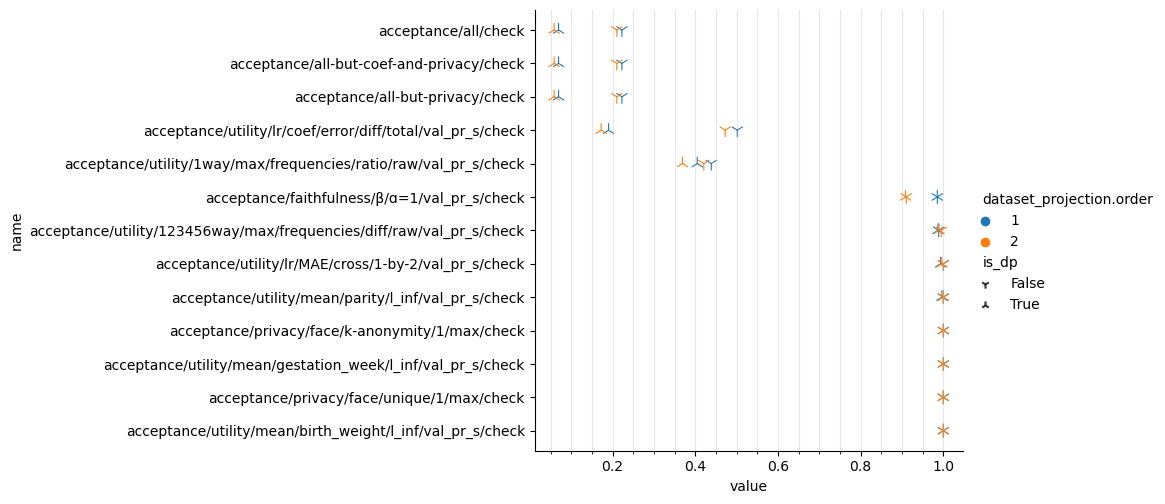

In [11]:
from matplotlib.ticker import AutoMinorLocator

g = sns.relplot(
    x="value",
    y="name",
    hue="dataset_projection.order",
    style="is_dp",
    s=100,
    markers=["1", "2"],
    data=(
        df.groupby("dataset_projection.order")
        .apply(lambda g: g.filter(regex="acceptance/.+/check$").mean())
        .T.sort_values(by="1")
        .reset_index()
        .assign(
            is_dp=lambda c: c["index"].str.contains("dp"),
            name=lambda c: c["index"].str.replace("dp_", ""),
        )
        .drop("index", axis=1)
        .melt(id_vars=["name", "is_dp"])
    ),
)
g.ax.xaxis.set_minor_locator(AutoMinorLocator(4))

g.ax.grid(which="both", axis="x", alpha=0.3)

In [12]:
(
    df.groupby("dataset_projection.order")
    .apply(lambda g: g.filter(regex=r"acceptance/all.*/check$").mean())
    .T.sort_values(by="1")
    .sort_index()
)

dataset_projection.order,1,2
acceptance/all-but-coef-and-privacy/check,0.222581,0.210345
acceptance/all-but-privacy/check,0.222581,0.210345
acceptance/all/check,0.222581,0.210345
dp_acceptance/all-but-coef-and-privacy/check,0.069355,0.058621
dp_acceptance/all-but-privacy/check,0.069355,0.058621
dp_acceptance/all/check,0.069355,0.058621


In [13]:
pd.crosstab(
    df["acceptance/all-but-privacy/check"],
    [df["dp_acceptance/all-but-privacy/check"], df["dataset_projection.order"]],
).unstack().to_frame()

0
dp_acceptance/all-but-privacy/check dataset_projection.order acceptance/all-but-privacy/check     
False                               1                        False                             475
                                                             True                              102
                                    2                        False                             452
                                                             True                               94
True                                1                        False                               7
                                                             True                               36
                                    2                        False                               6
                                                             True                               28

In [14]:
q = (
    df[
        (
            ~df["acceptance/all-but-privacy/check"]
            & df["dp_acceptance/all-but-privacy/check"]
        )
    ]
    .filter(regex="acceptance/.+/actual")
    .T
)
q.iloc[q.index.str.replace("dp_", "").argsort()]

,1125,1472,2664,3075,3240,5527,6817,6827,8292,10451,10455,10544,10634
dp_acceptance/all/actual,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
acceptance/all/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/faithfulness/β/ɑ=1/val_pr_s/actual,0.049912,0.043069,0.045869,0.047262,0.041631,0.037756,0.036019,0.037325,0.046319,0.036019,0.037237,0.035713,0.042081
dp_acceptance/faithfulness/β/ɑ=1/val_pr_s/actual,0.049546,0.041957,0.045830,0.047129,0.041428,0.037006,0.035899,0.035598,0.046072,0.035469,0.035898,0.035469,0.042004
dp_acceptance/privacy/face/k-anonymity/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/privacy/face/k-anonymity/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dp_acceptance/privacy/face/unique/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/privacy/face/unique/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/utility/123456way/max/frequencies/diff/raw/val_pr_s/actual,0.006406,0.005206,0.004700,0.004606,0.005325,0.003694,0.005662,0.004675,0.004331,0.004188,0.003594,0.003938,0.004831
dp_acceptance/utility/123456way/max/frequencies/diff/raw/val_pr_s/actual,0.006426,0.006212,0.003349,0.005099,0.005340,0.002217,0.004999,0.005254,0.003816,0.004214,0.002905,0.003948,0.004280


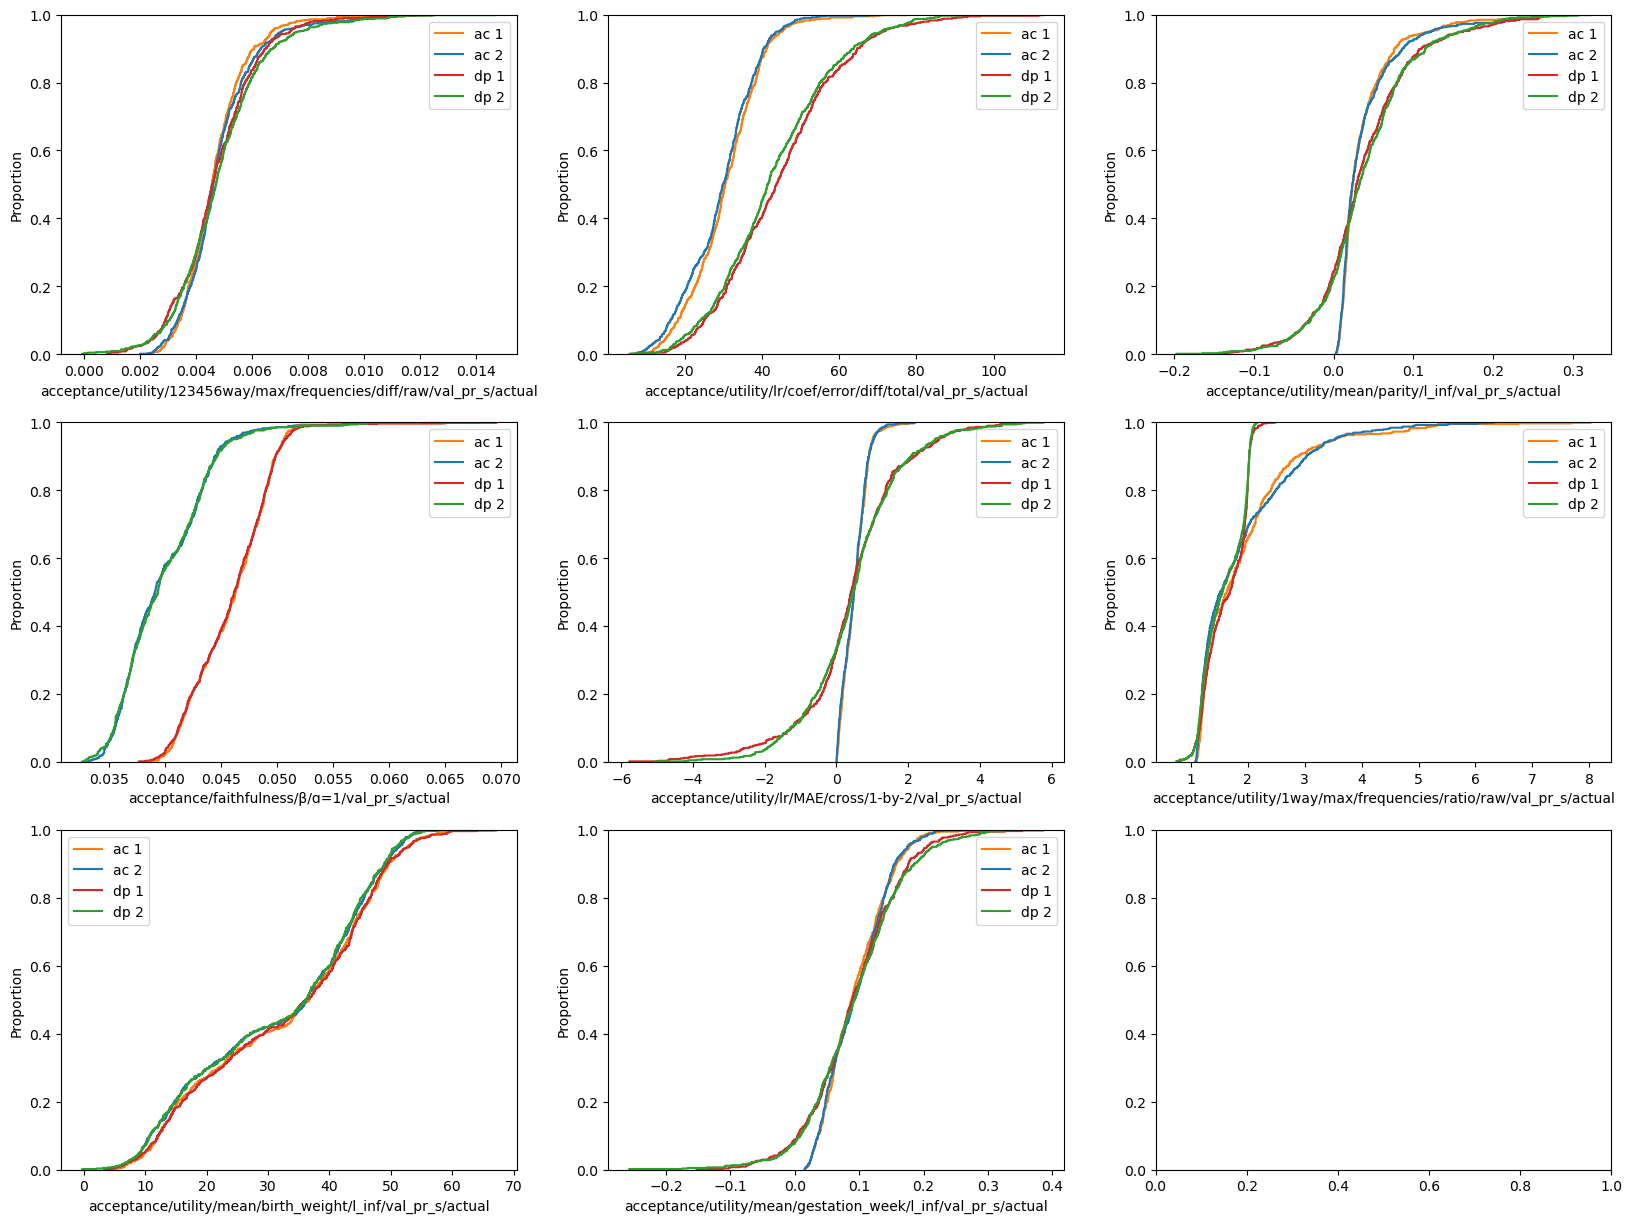

In [15]:
_, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

ac_cols = [
    c[:-7]
    for c in df.filter(regex="^acceptance/.+/actual").columns
    if "all" not in c and "privacy" not in c
]
for ax, column in zip(axes, ac_cols):
    sns.ecdfplot(
        df.sort_values("dataset_projection.order"),
        x=f"{column}/actual",
        hue="dataset_projection.order",
        hue_order=["1", "2"],
        palette=sns.color_palette()[:2],
        label="ac",
        ax=ax,
    )
    sns.ecdfplot(
        df,
        x=f"dp_{column}/actual",
        hue="dataset_projection.order",
        hue_order=["1", "2"],
        palette=sns.color_palette()[2:4],
        label="dp",
        ax=ax,
    )

    ax.legend(["ac 1", "ac 2", "dp 1", "dp 2"])

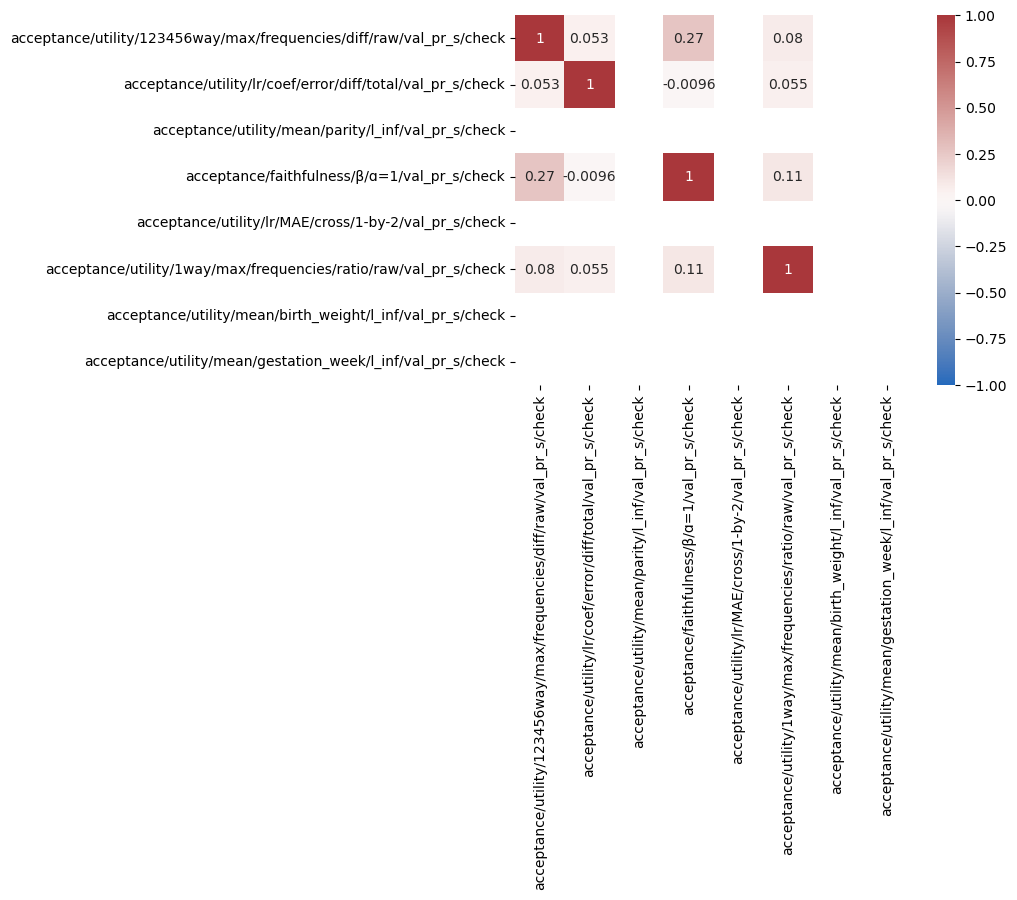

In [16]:
sns.heatmap(
    df[[f"{c}/check" for c in ac_cols]].astype(float).corr(),
    annot=True,
    cmap="vlag",
    vmin=-1,
    vmax=1,
)

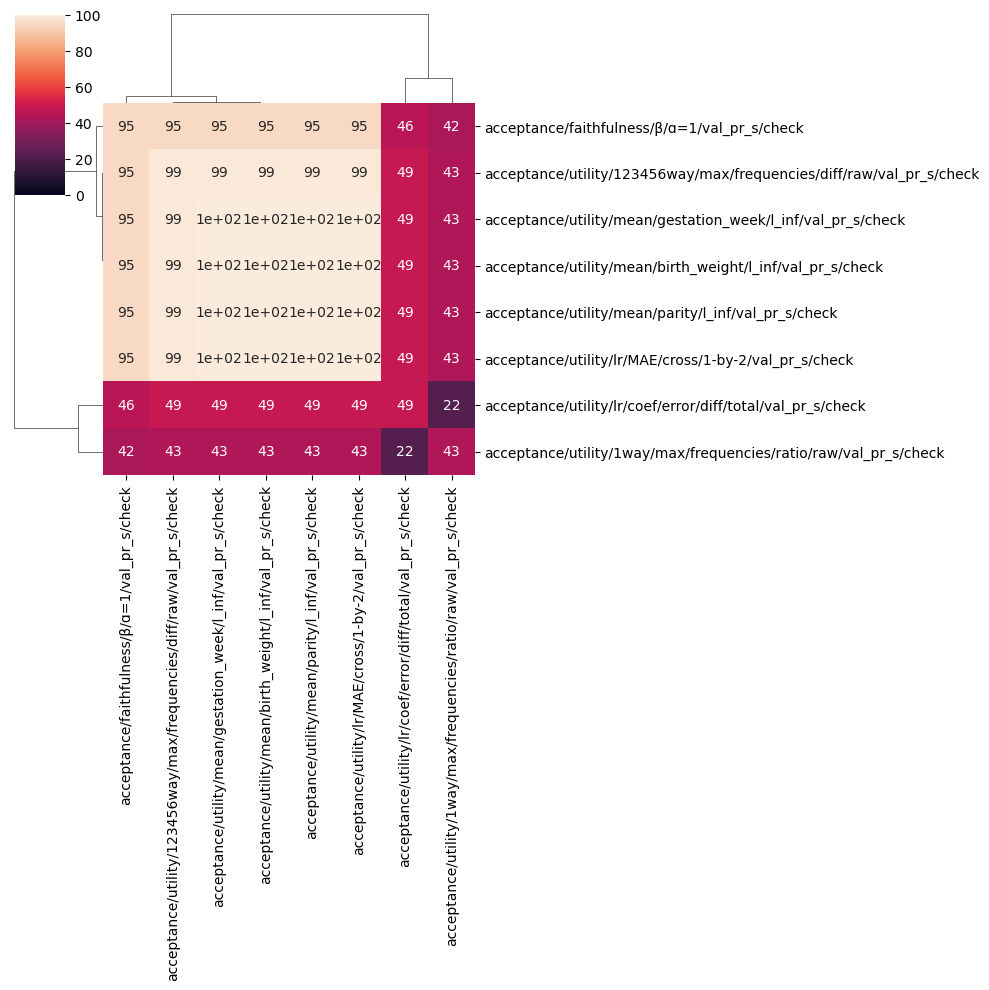

In [17]:
check_df = df[[f"{c}/check" for c in ac_cols]].astype(float).dropna()
sns.clustermap(
    (check_df.T @ check_df / len(check_df)).multiply(100).round(0).astype(int),
    annot=True,
    vmin=0,
    vmax=100,
)

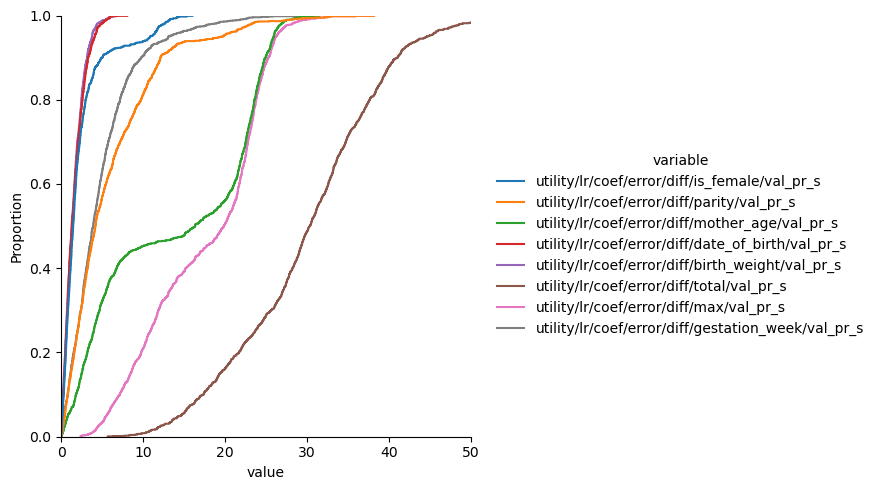

In [18]:
g = sns.displot(
    x="value",
    hue="variable",
    kind="ecdf",
    data=df.filter(regex="^utility/lr/coef/.+/val_pr_s").melt(),
)

g.set(xlim=(0, 50))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

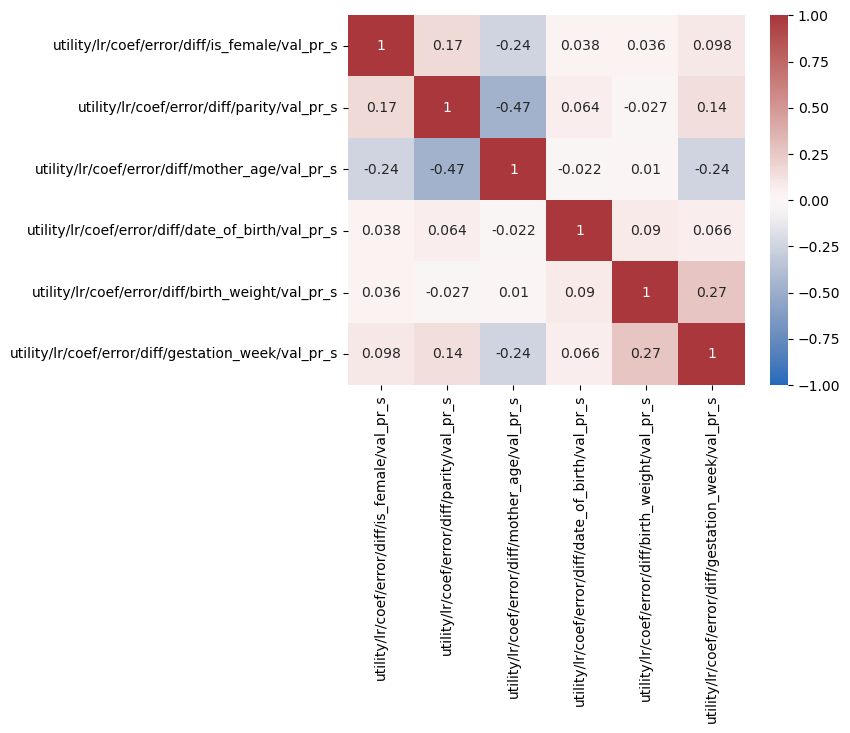

In [19]:
sns.heatmap(
    df.filter(regex="^utility/lr/coef/error/diff/(?!(max|total)).+/val_pr_s").corr(),
    annot=True,
    cmap="vlag",
    vmin=-1,
    vmax=1,
)

In [20]:
df[df["acceptance/all/check"] == True].filter(  # noqa: E712
    regex="acceptance/.+/actual"
).T.sort_index(key=lambda y: y.map(lambda x: x[3:] if x.startswith("dp_") else x))

,77,78,125,138,278,374,382,384,514,585,...,10939,10949,10987,11017,11023,11033,11035,11039,11099,11451
dp_acceptance/all/actual,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
acceptance/all/actual,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
acceptance/faithfulness/β/ɑ=1/val_pr_s/actual,0.042769,0.043081,0.040744,0.042162,0.037231,0.042331,0.047937,0.039431,0.039175,0.048238,...,0.049662,0.044306,0.046362,0.044419,0.036581,0.043650,0.042156,0.035325,0.043638,0.047238
dp_acceptance/faithfulness/β/ɑ=1/val_pr_s/actual,0.043185,0.042599,0.040344,0.042103,0.036482,0.041973,0.049008,0.038247,0.039784,0.048212,...,0.049483,0.044497,0.046398,0.045861,0.036950,0.041357,0.042385,0.034742,0.043274,0.046137
dp_acceptance/privacy/face/k-anonymity/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/privacy/face/k-anonymity/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dp_acceptance/privacy/face/unique/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/privacy/face/unique/1/max/actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acceptance/utility/123456way/max/frequencies/diff/raw/val_pr_s/actual,0.003856,0.004919,0.004738,0.002662,0.004600,0.003037,0.004894,0.004469,0.005437,0.005494,...,0.004669,0.004162,0.006831,0.004325,0.004019,0.004275,0.004825,0.004481,0.004694,0.005587
dp_acceptance/utility/123456way/max/frequencies/diff/raw/val_pr_s/actual,0.004338,0.004887,0.004748,0.002261,0.004847,0.004196,0.005563,0.004713,0.005247,0.005348,...,0.004714,0.002104,0.008521,0.003873,0.003909,0.004121,0.004442,0.003945,0.004877,0.005531


## Final Verdict

In [21]:
id_acceptance_all_grpby = df.groupby("id")["acceptance/all/check"]
id_acceptance_all_counts = id_acceptance_all_grpby.sum()
id_acceptance_all_mask = id_acceptance_all_counts > 0
accepted_all_ids = set(id_acceptance_all_counts[id_acceptance_all_mask].index)

print(f"{len(accepted_all_ids)=}")

len(accepted_all_ids)=120


In [22]:
assert (id_acceptance_all_grpby.size()[id_acceptance_all_mask] == 10).all()
print("Probability of success:", id_acceptance_all_grpby.mean().mean())

Probability of success: 0.21666666666666667


In [23]:
print("\n".join(sorted(f"{id_}.json" for id_ in accepted_all_ids)))

2921-0856-f51f.json
2921-0e2b-200e.json
2921-0e2b-f51f.json
2921-131e-200e.json
2921-131e-f51f.json
2921-1eea-200e.json
2921-1eea-f51f.json
2921-3d1a-200e.json
2921-3d1a-f51f.json
2921-477b-200e.json
2921-477b-f51f.json
2921-51de-f51f.json
2921-51f2-200e.json
2921-51f2-f51f.json
2921-5a5f-200e.json
2921-5a5f-f51f.json
2921-7ec5-f51f.json
2921-8328-200e.json
2921-8328-f51f.json
2921-9038-200e.json
2921-903d-f51f.json
2921-b56a-200e.json
2921-b56a-f51f.json
2921-b995-f51f.json
2921-c3cb-200e.json
2921-c965-200e.json
2921-c965-f51f.json
2921-d054-200e.json
2921-d054-f51f.json
2921-eef9-200e.json
2921-eef9-f51f.json
2921-f0e2-200e.json
2921-f0e2-f51f.json
2921-f7af-200e.json
60d7-0469-200e.json
60d7-0469-f51f.json
60d7-0e2b-200e.json
60d7-131e-200e.json
60d7-131e-f51f.json
60d7-1eea-200e.json
60d7-1eea-f51f.json
60d7-35d8-200e.json
60d7-35d8-f51f.json
60d7-3aa1-200e.json
60d7-3d1a-200e.json
60d7-3d1a-f51f.json
60d7-3ff8-200e.json
60d7-3ff8-f51f.json
60d7-477b-200e.json
60d7-477b-f51f.json
